In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#log_files_path = '/content/drive/My Drive/EIB project/'
import os 
import sys
sys.path.insert(0, os.path.abspath('./modules'))
import glob
import pandas as pd
#import features
import numpy as np
import tensorflow as tf
from tensorflow import keras
import collections
import random
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D,Concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Input
from keras import initializers, regularizers, constraints, optimizers, layers, models
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import re
from sklearn import metrics
from sklearn.model_selection import train_test_split
import nltk
import datetime
#from textblob import TextBlob as tb
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import inflect
from gensim import utils
import gensim.parsing.preprocessing as gsp
from gensim import utils
import gensim.parsing.preprocessing as gsp
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Define Configuration

In [ ]:
class TrainingConfig(object):
    # set training config
    epoches = 200
    learningRate = 0.005
    ##set cilpper
    clipnorm=1. 
    clipvalue=5
    
class ModelConfig(object):
    # set CNN model parameters
    embeddingSize = 200
    kernel_sizes=[3,4,5]
    filter_num=256
    
    
class Config(object):
    batchSize = 16
    max_features = 1500
    
    corpusSource= "real whole corpus.csv"
    scoreSource = "real BB company.csv"
    word2vecSource='skipgram_wordvec.txt'
    checkpoint_path="training_1/cp-{epoch:04d}.ckpt"
    numClasses = 1  
    
    test_size=0.2 

    model = ModelConfig()
    training = TrainingConfig()
    
# instant
config = Config()

##  Generate Dataset

In [ ]:
class Dataset(object):
    def __init__(self, config):
        self.config = config
        self._corpusSource = config.corpusSource
        self._scoreSource=config.scoreSource
        self._word2vecSource=config.word2vecSource
        self._embeddingSize = config.model.embeddingSize
        self._batchSize = config.batchSize
        self._test_size = config.test_size     
        self.max_features = config.max_features
        self.labelList = []
        self.maxlength=0
        
        self.trainX = []
        self.trainY = []
        self.testX = []
        self.testY = []
        
        self.embedding_matrix =[]
        
    def _readData(self, filePath1,filePath2):
        score=pd.read_csv(filePath1)
        score.drop(columns=['Unnamed: 0'],inplace=True)

        score.rename(columns={"Name":"company"},inplace=True)
        corpus=pd.read_csv(filePath2,names=['company','text'])
        data=pd.merge(corpus, score, on=['company'], how='inner').drop_duplicates('company').reset_index(drop=True)
        data.dropna(inplace=True)
        return data
    
    def get_wordnet_pos(self,pos_tag): # POS Tagging
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def remove_punctuation(self,words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def remove_special(self,words):
        """Remove special signs like &*"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[-,$()#+&*]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def replace_numbers(self,words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            try:
                if word.isdigit():
                    new_word = p.number_to_words(word)
                    new_words.append(new_word)
                else:
                    new_words.append(word)
            except:
                continue
        return new_words

    def remove_stopwords(self,words):
        """Remove stop words from list of tokenized words"""  
        stopwords = nltk.corpus.stopwords.words('english')
        myStopWords = []
        stopwords.extend(myStopWords)
        new_words = []
        for word in words:
            if word not in stopwords:
                new_words.append(word)
        return new_words


    def normalize_lemmatize(self,words):
        words = self.remove_special(words)
        words = self.remove_punctuation(words)
        words = self.replace_numbers(words)
        words = self.remove_stopwords(words)
        pos_tags = pos_tag(words) # POS Tagging
        # Lemmatize words based on tags
        words = [WordNetLemmatizer().lemmatize(t[0], self.get_wordnet_pos(t[1])) for t in pos_tags]
        # remove words with only one letter
        words = [t for t in words if len(t) > 1]
        #words = lemmatize_verbs(words)
        #words = stem_words(words)
        return words
    
    def _genTraintestData(self):
        new_data=self._readData(self._scoreSource,self._corpusSource)
        x_feature=new_data.values[:,1]
        for i in range(len(x_feature)):
            words = nltk.word_tokenize(x_feature[i])
            x_feature[i]=self.normalize_lemmatize(words)
        self.tokenizer = Tokenizer(num_words=self.max_features)
        self.tokenizer.fit_on_texts(x_feature)
        x_feature = np.array(self.tokenizer.texts_to_sequences(x_feature))
        for i in x_feature:
            self.maxlength=max(self.maxlength,len(i))
        x_feature = pad_sequences(x_feature,maxlen=self.maxlength)
        y=new_data.values[:,-1]
        y = np.asarray(y).astype(np.float32)
        x_train,x_test,y_train,y_test=train_test_split(x_feature,y,test_size=self._test_size,shuffle=True)
        self.trainX = x_train
        self.trainY = y_train
        self.testX = x_test
        self.testY = y_test
        
    def _getWordEmbedding(self):

        embeddings_index = dict(self.getcoefs(*z.split(" ")) for z in open(self._word2vecSource))
        all_embs = np.stack(embeddings_index.values())
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        embed_size = all_embs.shape[1]

        word_index = self.tokenizer.word_index
        nb_words = min(self.max_features, len(word_index)+1)
        self.embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        for word, i in word_index.items():
            if i >= self.max_features:
                continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: 
                self.embedding_matrix[i] = embedding_vector
    
    
    def getcoefs(self,word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    def genALL(self):
        self._genTraintestData()
        self._getWordEmbedding()
        
data = Dataset(config)
data.genALL()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:148: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


## Define Model

In [ ]:
class TextCNN(Model):

    def __init__(self,
                 maxlen,
                 max_features,
                 embedding_dims,
                 kernel_sizes,
                 filter_num,
                 embedding_matrix,
                 class_num=1,
                 last_activation='linear'):
        super(TextCNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.kernel_sizes = kernel_sizes
        self.class_num = class_num
        self.filter_num=filter_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen,weights=[embedding_matrix])
        self.convs = []
        self.max_poolings = []
        for kernel_size in self.kernel_sizes:
            self.convs.append(Conv1D(filter_num, kernel_size, activation='relu'))
            self.max_poolings.append(GlobalMaxPool1D())
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextCNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextCNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        # Embedding part can try multichannel as same as origin paper
        embedding = self.embedding(inputs)
        convs = []
        for i in range(len(self.kernel_sizes)):
            c = self.convs[i](embedding)
            c = self.max_poolings[i](c)
            convs.append(c)
        x = Concatenate()(convs)
        x = Dropout(0.5)(x)
        output = self.classifier(x)
        return output

In [ ]:
class CNNModel:
    def __init__(self,data,config):

        self.data=data
        self.config=config
        self.maxlength=data.maxlength
        self.max_features=data.max_features
        self.embed_size=config.model.embeddingSize
        self.kernel_sizes=config.model.kernel_sizes
        self.filter_num=config.model.filter_num
        self.learning_rate=config.training.learningRate 
        self.clipnorm=config.training.clipnorm
        self.clipvalue=config.training.clipvalue
        self.batch_size=config.batchSize
        self.epoch=config.training.epoches 
        self.embedding_matrix=data.embedding_matrix
        self.model=self.build_model()
        
    def build_model(self):
        model = TextCNN(self.maxlength, self.max_features, self.embed_size,self.kernel_sizes,self.filter_num,self.embedding_matrix)
        adam=keras.optimizers.Adam(lr=self.learning_rate,clipnorm=self.clipnorm,clipvalue=self.clipvalue)
        model.compile(loss='mse', optimizer=adam)
        return model
    
    def train(self):

        checkpoint_path = self.config.checkpoint_path
        checkpoint_dir = os.path.dirname(checkpoint_path)
        cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1,period=10)
        self.model.save_weights(checkpoint_path.format(epoch=0))
        cks = [EarlyStopping(monitor='val_loss',mode='min', patience=5),cp_callback] 
        self.model.layers[1].trainable = False
        self.history = self.model.fit(self.data.trainX,self.data.trainY, batch_size=self.batch_size, callbacks=cks, epochs=self.epoch, validation_data=(self.data.testX, self.data.testY))
        
    def plot_result(self):
        history1=self.history.history
        plt.figure(figsize=(12,6))
        plt.subplot(1, 2, 1)
        plt.plot(history1["loss"],label="loss")
        plt.plot(history1["val_loss"],label="valuation loss")
        plt.title('Loss')
        plt.xlabel('epoch')
        plt.legend()

    

## Model Training

In [ ]:
# Model Training
model=CNNModel(data,config)
model.train()

Train on 436 samples, validate on 110 samples
Epoch 1/200
436/436 [==============================] - 61s 140ms/step - loss: 644.2344 - val_loss: 531.2568
Epoch 2/200
436/436 [==============================] - 57s 130ms/step - loss: 505.5502 - val_loss: 427.7275
Epoch 3/200
436/436 [==============================] - 57s 130ms/step - loss: 402.1469 - val_loss: 351.1440
Epoch 4/200
436/436 [==============================] - 57s 130ms/step - loss: 330.3699 - val_loss: 298.8120
Epoch 5/200
436/436 [==============================] - 57s 130ms/step - loss: 274.9404 - val_loss: 267.4096
Epoch 6/200
436/436 [==============================] - 57s 130ms/step - loss: 228.2601 - val_loss: 247.5170
Epoch 7/200
436/436 [==============================] - 57s 130ms/step - loss: 213.9846 - val_loss: 234.8164
Epoch 8/200
436/436 [==============================] - 56s 130ms/step - loss: 192.4972 - val_loss: 226.6190
Epoch 9/200
436/436 [==============================] - 57s 130ms/step - loss: 186.9235 - v

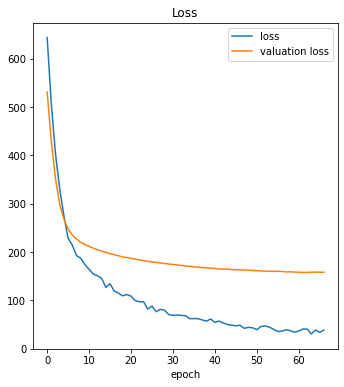

In [ ]:
model.plot_result()
